## MSE 

In [77]:
import os
from pathlib import Path
import numpy as np
from scipy.integrate import solve_ivp

from matplotlib import pyplot as plt
import tikzplotlib

In [78]:
# Exact dynamics, approximate solution

def dudt(t, u, c, r, s, l):
    
    return np.sqrt(c**2 + 4 * r**2 * u**2) * (s - l * u)

def d2udt2(t, u, c, r, s, l):
    
    return 4 * r * u * (s - l * u)**2 - l * (s - l * u) * (c**2 + 4 * r * u**2)

def solve_dynamics(u0, t, c, r, s, l): 
    
    u0 = np.ma.atleast_1d(u0)
    res = solve_ivp(dudt, (0, max(t)), u0, t_eval=t, args = (c, r, s, l))
    
    if not res["success"]:
        stat, msg = res.get("status"), res.get("message")
        print(f"ODE solver not successful. Termination {stat}. Message: {msg}")
    
    return res["y"].squeeze()


def loop_dynamics_l(u0, t, c, r, s, l_list):
    
    u_traj = []
    for l in l_list:
        u_traj.append(solve_dynamics(u0, t, c, r, s, l))
        
    return np.row_stack(u_traj)


def loop_dynamics_s(u0, t, c, r, s_list, l):
    
    u_traj = []
    for s in s_list:
        u_traj.append(solve_dynamics(u0, t, c, r, s, l))
        
    return np.row_stack(u_traj)


def loop_dynamics_u0(u0_list, t, c, r, s_list, l):
    
    u_traj = []
    for u0 in u0_list:
        u_traj.append(solve_dynamics(u0, t, c, r, s, l))
        
    return np.row_stack(u_traj)


def loop_dynamics_r_c(u0, t, c_list, r_list, s, l):
    
    u_traj = []
    for c, r in zip(c_list, r_list):
        u_traj.append(solve_dynamics(u0, t, c, r, s, l))
        
    return np.row_stack(u_traj)


In [79]:
# MSE 

def z_true(s, l, e):
    return s / l - e / np.sqrt(l)


def mse_global(s, l, u):
    return (s / l - u)**2


def mse_true(s, l, e, u):
    return (z_true(s, l, e) - u)**2


def mse_train(u1, u2, s1, s2, l1, l2, d, p):
    
    return ((d - p) / d) * l1 * mse_global(s1, l1, u1), (p / d) * l2 * mse_global(s2, l2, u2)


def mse_test(u1, u2, s1, s2, l1, l2, e1, e2, d, p):
    
    return ((d - p) / d) * l1 * mse_true(s1, l1, e1, u1), (p / d) * l2 * mse_true(s2, l2, e2, u2)  

In [80]:
def plot_res(mse_train_1, mse_train_2, mse_test_1, mse_test_2, t_range, it_range, it="", titles=["Train", "Test", "Test 1", "Test 2"], vmax=None, log_x_scale=True, log_y_scale=True, fig_name="test"):
    
    fig, ax = plt.subplots(1, 4, figsize = (24, 5))
    
    
    if log_x_scale:
        new_ticks_x = np.linspace(0, mse_train_1.shape[0] - 1, int(np.log10(t_range.max())) + 1).astype(int)
    else:
        new_ticks_x = np.linspace(0, mse_train_1.shape[0] - 1, 5).astype(int)

    new_ticks_y = np.linspace(0, mse_train_1.shape[0] - 1, 5).astype(int)

    
    for i, res in enumerate([mse_train_1 + mse_train_2, mse_test_1 + mse_test_2, mse_test_1, mse_test_2]):
        im = ax[i].imshow(res, cmap="viridis", vmax=vmax)
        fig.colorbar(im, ax=ax[i])
    
    for i in range(ax.shape[0]):
        ax[i].set_title(titles[i]) 
        
        ax[i].set_xlabel("t")
        ax[i].set_xticks(new_ticks_x)
        
        if log_x_scale:
            ax[i].set_xticklabels([f"$10^{{{x}}}$" for x in np.round(np.log10(t_range[new_ticks_x]), 1).astype(int)]) # OBS: AVRUNDNINGEN!!!
        else:
            ax[i].set_xticklabels(t_range[new_ticks_x].astype(int)) 

        ax[i].set_ylabel(it)
        ax[i].set_yticks(new_ticks_y)
        
        if log_y_scale:
            ax[i].set_yticklabels([f"10^{{{x}}}" for x in np.round(np.log10(it_range[new_ticks_y]), 2)]) # OBS: AVRUNDNINGEN!!!
        else:
            ax[i].set_yticklabels(np.round(it_range[new_ticks_y], 2)) # OBS: AVRUNDNINGEN!!!
            
    savedir="res/mse/"
    if not os.path.exists(Path(savedir)):
        os.mkdir(Path(savedir))
            
    #tikzplotlib.save(Path(savedir + fig_name + "_surface_plot.tikz"))
    plt.savefig(Path(savedir + fig_name + "_surface_plot.png"))
    
    plt.show()
    
def plot_curves(mse_train_1, mse_train_2, mse_test_1, mse_test_2, t_range, it_range, it="", titles=["Train", "Test", "Test 1", "Test 2"], ylim=None, log_x_scale=True, log_y_scale=True, fig_name="test"):
    
    fig, ax = plt.subplots(1, 4, figsize = (24, 5))
        
        
    for i in range(0, mse_train_1.shape[-1], int(mse_train_1.shape[-1] / 5)) :
        
        if log_y_scale:
            lab = it + " = " + fr"10^{{{np.round(np.log10(it_range[i]), 2)}}}"
        else:
            lab = it + " = " + str(round(it_range[i], 2))
            
        for j, res in enumerate([mse_train_1 + mse_train_2, mse_test_1 + mse_test_2, mse_test_1, mse_test_2]):
            ax[j].plot(t_range, res[i, :], label=lab)

    for i in range(4):
                
        ax[i].set_title(titles[i]) 
        ax[i].legend(loc=2)

        
        ax[i].set_xlabel("t")
        ax[i].set_ylabel("MSE")
        
        ax[i].set_ylim([0, ylim])
        
        if log_x_scale:
            ax[i].set_xscale("log")

    savedir="res/mse/"
    if not os.path.exists(Path(savedir)):
        os.mkdir(Path(savedir))
            
    #tikzplotlib.save(Path(savedir + fig_name + "_example_plots.tikz"))
    plt.savefig(Path(savedir + fig_name + "_example_plots.png"))
    
    plt.show()

# Test example

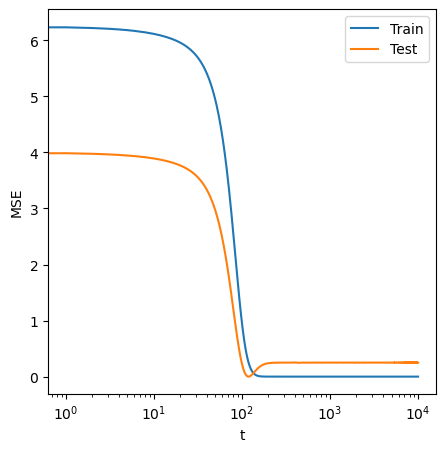

In [81]:
# Test

# Hps
tau = 10000
res = 10000
ts = np.linspace(0, tau, res)

c, r = 0.001, 0.01
s = 2.5
l1, l2 = 1, 10
d = 10
p1, p2 = 0, 9
u0 = 0.001
e = 0.5

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

u1 = solve_dynamics(u0, ts, c, r, s, l1)
u2 = solve_dynamics(u0, ts, c, r, s, l2)
mset_1, mset_2 = mse_train(u1, u2, s, s, l1, l2, d, p1)
mseg_1, mseg_2 = mse_test(u1, u2, s, s, l1, l2, e, e, d, p1)
ax.plot(ts, mset_1 + mset_2, label = "Train") 
ax.plot(ts, mseg_1 + mseg_2, label = "Test")

ax.set_xlabel("t")
ax.set_ylabel("MSE")
ax.set_xscale("log")
ax.legend()

plt.show()

# Test example linear model

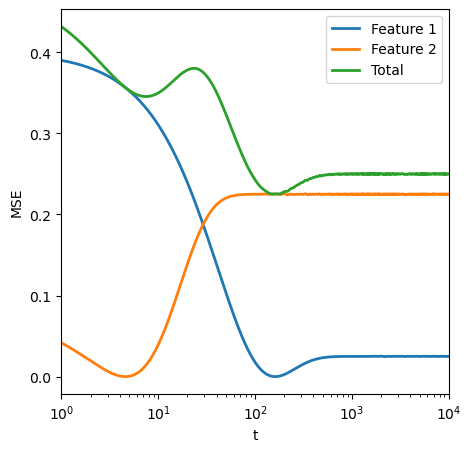

In [82]:
# Test

# Hps
tau = 10000
res = 1000
ts = np.geomspace(1, tau, res)

c, r = 0.01, 0
s = 2.5
l1, l2 = 1, 10
d = 10
p1, p2 = 0, 9
u0 = 0.0001
e = 0.5

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

u1 = solve_dynamics(u0, ts, c, r, s, l1)
u2 = solve_dynamics(u0, ts, c, r, s, l2)
mset_1, mset_2 = mse_train(u1, u2, s, s, l1, l2, d, p2)
mseg_1, mseg_2 = mse_test(u1, u2, s, s, l1, l2, e, e, d, p2)
ax.plot(ts, mseg_1, label = "Feature 1", lw=2) 
ax.plot(ts, mseg_2, label = "Feature 2", lw=2) 
ax.plot(ts, mseg_1 + mseg_2, label = "Total", lw=2)

ax.set_xlabel("t")
ax.set_ylabel("MSE")
ax.set_xlim([1, tau])
ax.set_xscale("log")
ax.legend()

tikzplotlib.save(Path("dd_example.tikz"))

plt.show()

# Test example, derivatives

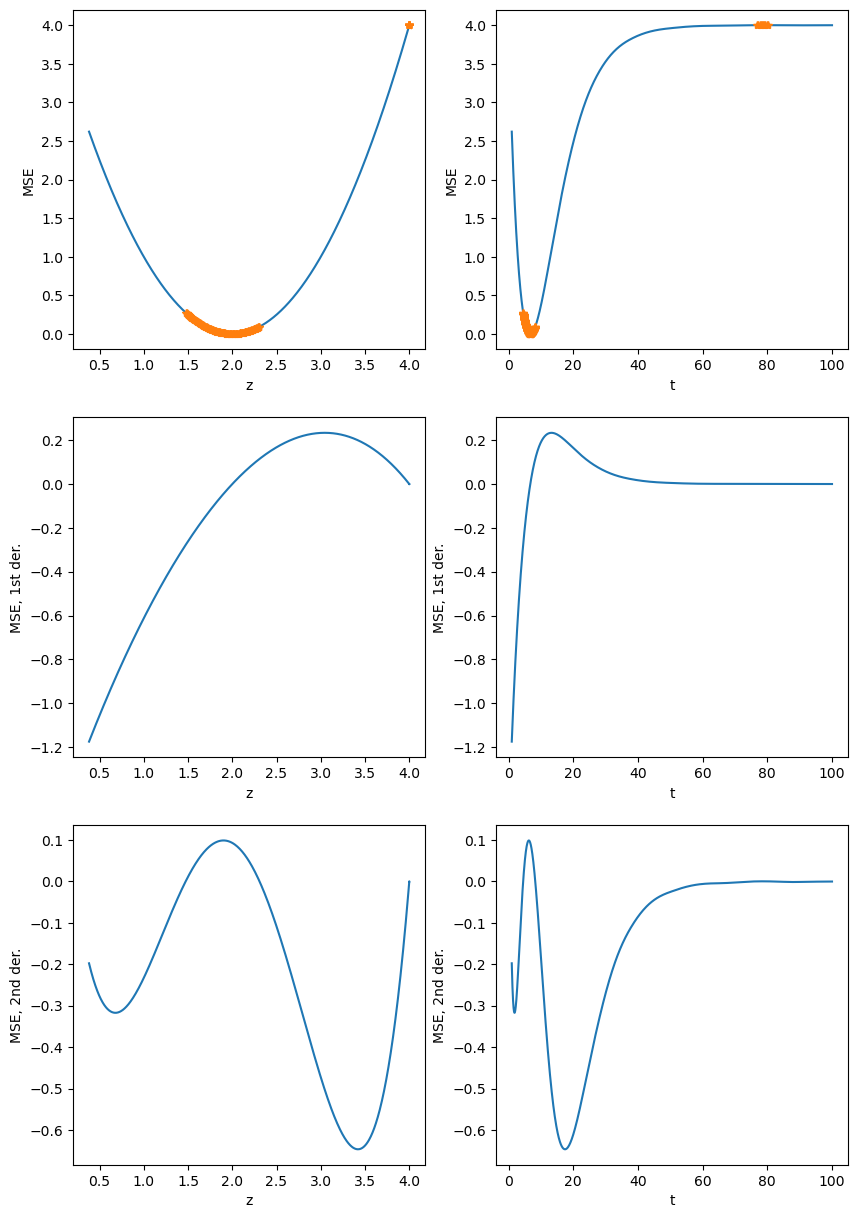

In [83]:
# Hps
tau = 100
res = 1000
ts = np.geomspace(1, tau, res)

c, r = 0.1, 0.01
s = 4
l = 1
d = 10
p1, p2 = 0, 9
u0 = 0.0001
q = 0.5

u1 = solve_dynamics(u0, ts, c, r, s, l)

fig, ax = plt.subplots(3, 2, figsize=(10, 15))


diff = ((1-q)*s/l - u1)
du1dt = dudt(ts, u1, c, r, s, l) 

mse = l * diff**2
dmsedt = - 2 * l * ((1-q)*s/l - u1) * du1dt
d2msedt2 = 2 * l * (du1dt**2 - diff * d2udt2(ts, u1, c, r, s, l))

ax[0, 0].plot(u1, mse)
ax[0, 0].plot(u1[d2msedt2 >= 0], mse[d2msedt2 >= 0], '*')
ax[1, 0].plot(u1, dmsedt)
ax[2, 0].plot(u1, d2msedt2)

ax[0, 1].plot(ts, mse)
ax[0, 1].plot(ts[d2msedt2 >= 0], mse[d2msedt2 >= 0], '*')
ax[1, 1].plot(ts, dmsedt)
ax[2, 1].plot(ts, d2msedt2)

for i in range(3):
    ax[i, 0].set_xlabel("z")
    ax[i, 1].set_xlabel("t")
    #ax[i, 1].set_xscale("log")
    
for i in range(2):
    ax[0, i].set_ylabel("MSE")
    ax[1, i].set_ylabel("MSE, 1st der.")
    ax[2, i].set_ylabel("MSE, 2nd der.")

# Test example, derivatives approx.

In [89]:
# Assume s/l < c/(2r)

def dudtapprox(t, u, c, r, s, l):
    
    return (0.96 * c + 2 * 0.4 * r * u) * (s - l * u)

def d2udt2approx(t, u, c, r, s, l):
    
    return 0.8 * r * (s - l *u)**2 * (0.96 * c + 0.8 * r * u) - l * (s - l * u) * (0.96 * c + 0.8 * r * u)**2

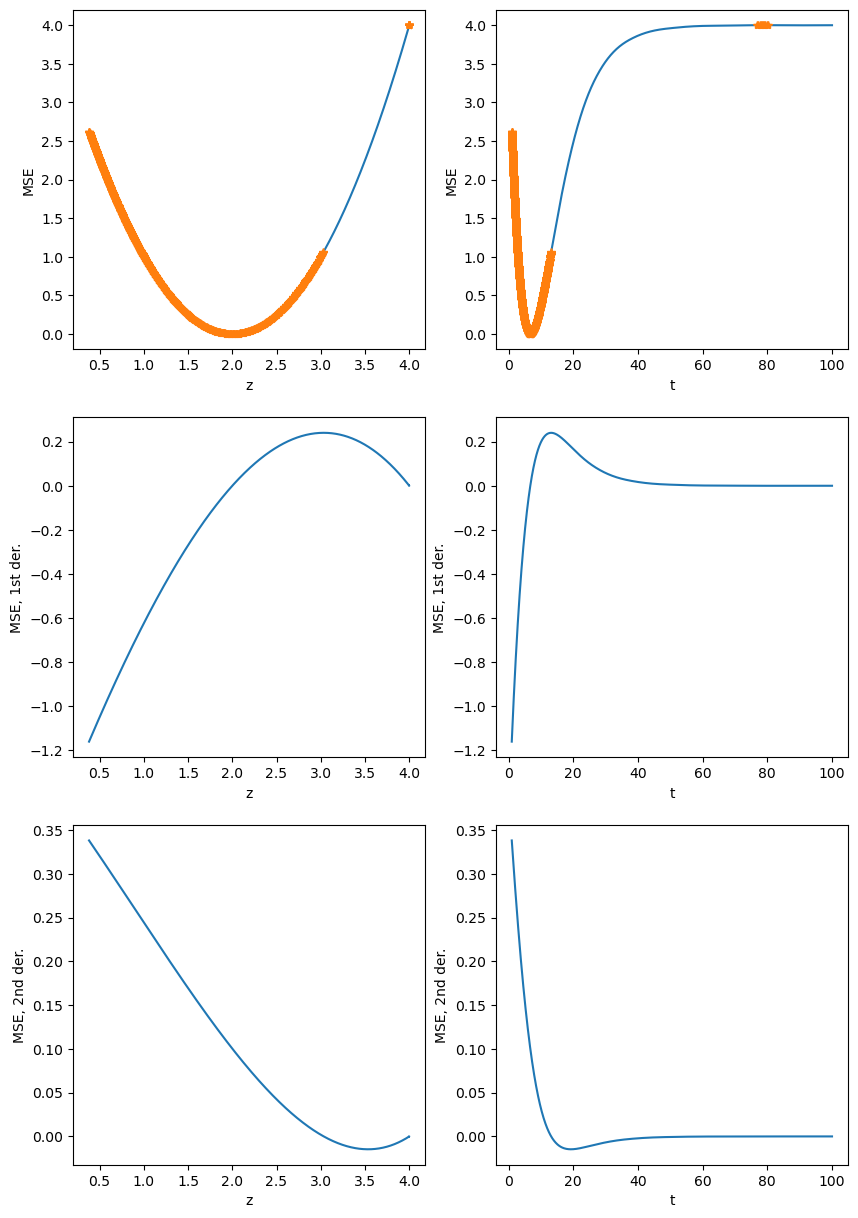

In [90]:
# Hps
tau = 100
res = 1000
ts = np.geomspace(1, tau, res)

c, r = 0.1, 0.01
s = 4
l = 1
d = 10
p1, p2 = 0, 9
u0 = 0.0001
q = 0.5

u1 = solve_dynamics(u0, ts, c, r, s, l)

fig, ax = plt.subplots(3, 2, figsize=(10, 15))


diff = ((1-q)*s/l - u1)
du1dt = dudtapprox(ts, u1, c, r, s, l) 

mse = l * diff**2
dmsedt = - 2 * l * ((1-q)*s/l - u1) * du1dt
d2msedt2 = 2 * l * (du1dt**2 - diff * d2udt2approx(ts, u1, c, r, s, l))

ax[0, 0].plot(u1, mse)
ax[0, 0].plot(u1[d2msedt2 >= 0], mse[d2msedt2 >= 0], '*')
ax[1, 0].plot(u1, dmsedt)
ax[2, 0].plot(u1, d2msedt2)

ax[0, 1].plot(ts, mse)
ax[0, 1].plot(ts[d2msedt2 >= 0], mse[d2msedt2 >= 0], '*')
ax[1, 1].plot(ts, dmsedt)
ax[2, 1].plot(ts, d2msedt2)

for i in range(3):
    ax[i, 0].set_xlabel("z")
    ax[i, 1].set_xlabel("t")
    #ax[i, 1].set_xscale("log")
    
for i in range(2):
    ax[0, i].set_ylabel("MSE")
    ax[1, i].set_ylabel("MSE, 1st der.")
    ax[2, i].set_ylabel("MSE, 2nd der.")

# Test example, derivatives, $r=\eta=0$

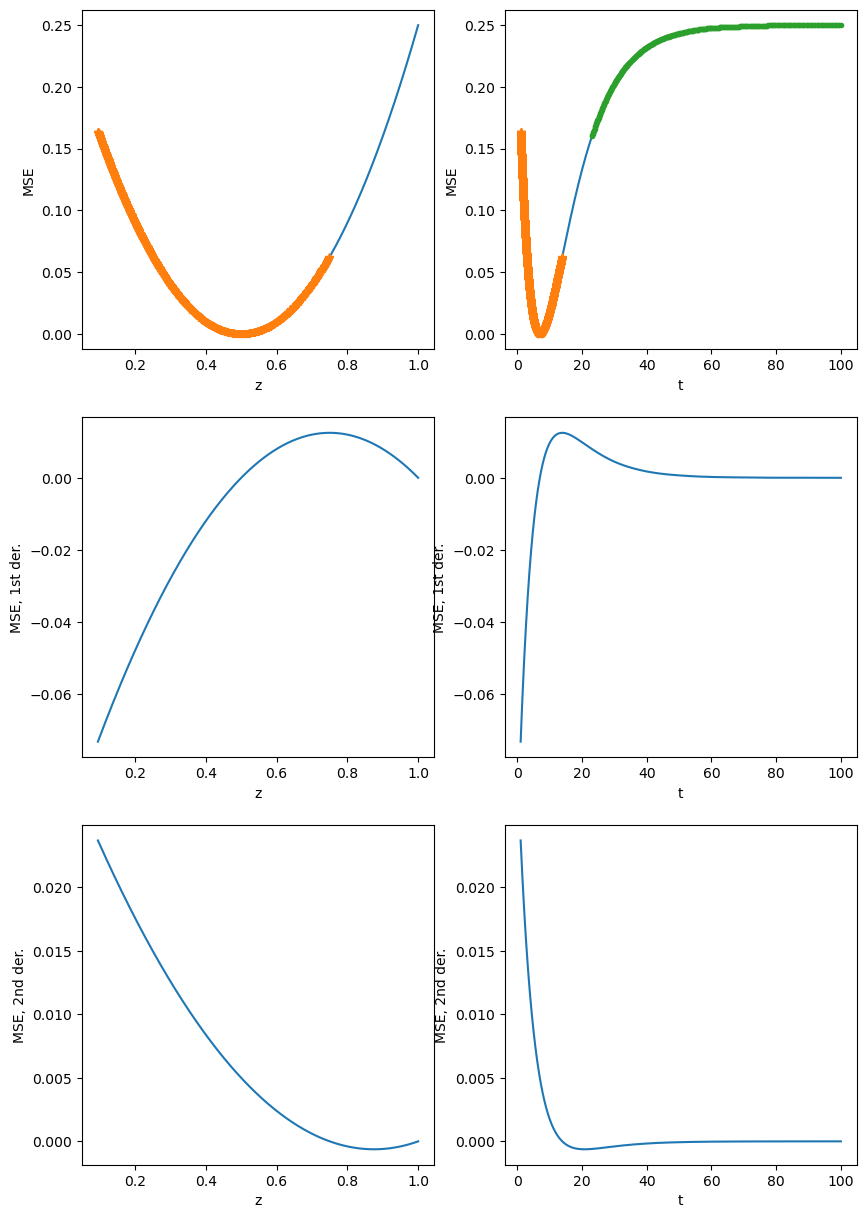

In [104]:
# Hps
tau = 100
res = 1000
ts = np.geomspace(1, tau, res)

c, r = 0.1, 0
s = 1
l = 1
d = 10
p1, p2 = 0, 9
u0 = 0.0001
q = 0.5

u1 = solve_dynamics(u0, ts, c, r, s, l)

fig, ax = plt.subplots(3, 2, figsize=(10, 15))


diff = ((1-q)*s/l - u1)
du1dt = dudt(ts, u1, c, r, s, l) 

mse = l * diff**2
dmsedt = - 2 * l * ((1-q)*s/l - u1) * du1dt
d2msedt2 = 2 * l * (du1dt**2 - diff * d2udt2(ts, u1, c, r, s, l))

ax[0, 0].plot(u1, mse)
ax[0, 0].plot(u1[d2msedt2 >= 0], mse[d2msedt2 >= 0], '*')
ax[1, 0].plot(u1, dmsedt)
ax[2, 0].plot(u1, d2msedt2)

ax[0, 1].plot(ts, mse)
ax[0, 1].plot(ts[d2msedt2 >= 0], mse[d2msedt2 >= 0], '*')

p = 0.1 # Konvexitetsbegreppet är ju starkt kopplat till värdet på q
ax[0, 1].plot(ts[u1 >= (1-p) * s / l], mse[u1 >= (1-p) * s / l], '.')

ax[1, 1].plot(ts, dmsedt)
ax[2, 1].plot(ts, d2msedt2)

for i in range(3):
    ax[i, 0].set_xlabel("z")
    ax[i, 1].set_xlabel("t")
    #ax[i, 1].set_xscale("log")
    
for i in range(2):
    ax[0, i].set_ylabel("MSE")
    ax[1, i].set_ylabel("MSE, 1st der.")
    ax[2, i].set_ylabel("MSE, 2nd der.")

# Test example, derivatives, $c=\gamma=0$

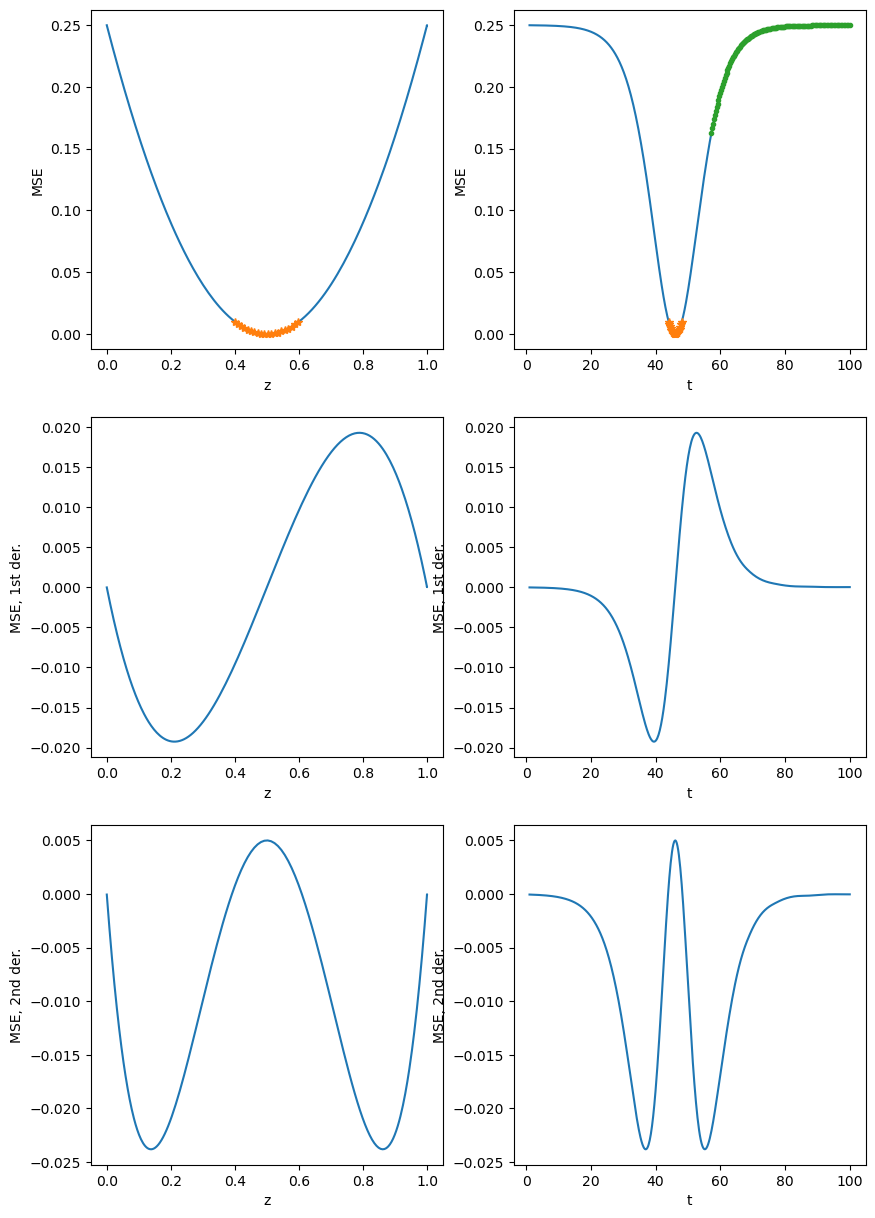

In [103]:
# Hps
tau = 100
res = 1000
ts = np.geomspace(1, tau, res)

c, r = 0, 0.1
s = 1
l = 1
d = 10
p1, p2 = 0, 9
u0 = 0.0001
q = 0.5

u1 = solve_dynamics(u0, ts, c, r, s, l)

fig, ax = plt.subplots(3, 2, figsize=(10, 15))


diff = ((1-q)*s/l - u1)
du1dt = dudt(ts, u1, c, r, s, l) 

mse = l * diff**2
dmsedt = - 2 * l * ((1-q)*s/l - u1) * du1dt
d2msedt2 = 2 * l * (du1dt**2 - diff * d2udt2(ts, u1, c, r, s, l))

ax[0, 0].plot(u1, mse)
ax[0, 0].plot(u1[d2msedt2 >= 0], mse[d2msedt2 >= 0], '*')
ax[1, 0].plot(u1, dmsedt)
ax[2, 0].plot(u1, d2msedt2)

ax[0, 1].plot(ts, mse)
ax[0, 1].plot(ts[d2msedt2 >= 0], mse[d2msedt2 >= 0], '*')

p = 0.1 # Konvexitetsbegreppet är ju starkt kopplat till värdet på q
ax[0, 1].plot(ts[u1 >= (1-p) * s / l], mse[u1 >= (1-p) * s / l], '.')

ax[1, 1].plot(ts, dmsedt)
ax[2, 1].plot(ts, d2msedt2)

for i in range(3):
    ax[i, 0].set_xlabel("z")
    ax[i, 1].set_xlabel("t")
    #ax[i, 1].set_xscale("log")
    
for i in range(2):
    ax[0, i].set_ylabel("MSE")
    ax[1, i].set_ylabel("MSE, 1st der.")
    ax[2, i].set_ylabel("MSE, 2nd der.")

# Counterexample, incremental learning

IndexError: index 0 is out of bounds for axis 0 with size 0

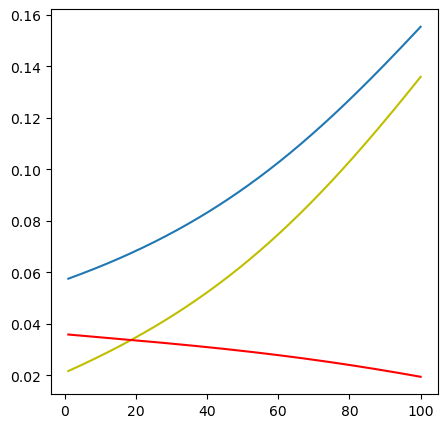

In [88]:
# Example when incremental learning is not necessary to observe epoch-wise double descent
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# OBS: MÅSTE HITTA PÅ NYTT (KOLLA BARA DITT VILLKOR SÅ BÖR DU VETA HUR DU KAN SÄTTA EPSILON TYP)
c, r = 0.001, 0.01

l2 = 1
q = 5
p = 1

u1 = solve_dynamics(u0, ts, c, r, s, l2 * q)
u2 = solve_dynamics(u0, ts, c, r, s, l2)

e1, e2 = e * 1.2, e * 0.8

mset_1, mset_2 = mse_train(u1, u2, s, s, l2 * q, l2, d, p)
mseg_1, mseg_2 = mse_test(u1, u2, s, s, l2 * q, l2, e1, e2, d, p)
ax.plot(ts, mseg_1, label = r"$z_1(t)$", c='y')
ax.plot(ts, mseg_2, label = r"$z_2(t)$", c='r') 
ax.plot(ts, mseg_1 + mseg_2, label = "Total")
#ax.plot(ts, mset_1, label = r"$z_2(t)$")
#ax.plot(ts, mset_2, label = r"$z_1(t)$")
#ax.plot(ts, mset_1 + mset_2, label = "Total")


# Assume u(0) < u(T)
rho = 0.25
t_lb = ts[u1 >= (1 - rho) * s / (l2 * q)][0]
t_ub = ts[u2 <= (rho * s / l2)][-1]
              
ax.axvline(x=t_lb, ls='--', c='y', label=r"$t_1^{\rho z_1^*}$")
ax.axvline(x=t_ub, ls='--', c='r', label=r"$t_2^{(1-\rho)z_2^*}$")

ax.set_xlabel("t")
ax.set_ylabel("MSE")
ax.set_xscale("log")

ax.legend()

plt.show()

In [ ]:
# Example when incremental learning is not necessary to observe epoch-wise double descent
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

l2 = 1
q = 10
p = 1

u1 = solve_dynamics(u0, ts, c, r, s, l2 * q)
u2 = solve_dynamics(u0, ts, c, r, s, l2)

e1, e2 = e * 0.8, e * 1.2

mset_1, mset_2 = mse_train(u1, u2, s, s, l2 * q, l2, d, p)
mseg_1, mseg_2 = mse_test(u1, u2, s, s, l2 * q, l2, e1, e2, d, p)
ax.plot(ts, mseg_1, label = r"$z_1(t)$", c='y')
ax.plot(ts, mseg_2, label = r"$z_2(t)$", c='r') 
ax.plot(ts, mseg_1 + mseg_2, label = "Total")
#ax.plot(ts, mset_1, label = r"$z_2(t)$")
#ax.plot(ts, mset_2, label = r"$z_1(t)$")
#ax.plot(ts, mset_1 + mset_2, label = "Total")


# Assume u(0) < u(T)
rho = 0.25
t_lb = ts[u1 >= (1 - rho) * s / (l2 * q)][0]
t_ub = ts[u2 <= (rho * s / l2)][-1]
              
ax.axvline(x=t_lb, ls='--', c='y', label=r"$t_1^{\rho z_1^*}$")
ax.axvline(x=t_ub, ls='--', c='r', label=r"$t_2^{(1-\rho)z_2^*}$")

ax.set_xlabel("t")
ax.set_ylabel("MSE")
ax.set_xscale("log")

ax.legend()

plt.show()

In [ ]:
# Test
# Example when incremental learning is not necessary to observe epoch-wise double descent
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

l2 = 1
q = 10
p = 1

u1 = solve_dynamics(u0, ts, c, r, s, l2 * q)
u2 = solve_dynamics(u0, ts, c, r, s, l2)

e1, e2 = e * 0.8, e * 1.2

mset_1, mset_2 = mse_train(u1, u2, s, s, l2 * q, l2, d, p)
mseg_1, mseg_2 = mse_test(u1, u2, s, s, l2 * q, l2, e1, e2, d, p)
ax.plot(ts, mseg_1, label = r"$z_1(t)$", c='y')
ax.plot(ts, mseg_2, label = r"$z_2(t)$", c='r') 
ax.plot(ts, mseg_1 + mseg_2, label = "Total")
#ax.plot(ts, mset_1, label = r"$z_2(t)$")
#ax.plot(ts, mset_2, label = r"$z_1(t)$")
#ax.plot(ts, mset_1 + mset_2, label = "Total")


# Assume u(0) < u(T)
rho = 0.25
t_lb = ts[u1 >= (1 - rho) * s / (l2 * q)][0]
t_ub = ts[u2 <= (rho * s / l2)][-1]

rho1, rho2 = 0.9, 0.9

# Assume u(0) < u(T)
t_lb = ts[u1 >= rho1 * s / (l2 * q)][0]
t_ub = ts[u2 <= rho2 * z_true(s, l2, e2)][-1]

ax.axvline(x=t_lb, ls='--', c='y', label=r"$t_1^{\rho_1 z_1^*}$")
ax.axvline(x=t_ub, ls='--', c='r', label=r"$t_2^{\rho_2 \bar{z}_2}$")

ax.set_xlabel("t")
ax.set_ylabel("MSE")
ax.set_xscale("log")
ax.legend()

plt.show()

# Effect of hps

# Changing $l2=\lambda_2$

# c < r

In [ ]:
tau = 10000
res = 201
d, p2 = 10, 9
s = 2.5
l1, l2 = 1, 10
l_min, l_max = 0.01, 100

t_range = np.geomspace(1, tau, res)
l_range = np.geomspace(l_min, l_max, res)
_, ls = np.meshgrid(t_range, l_range)

c, r = 0.001, 0.01

u1 = solve_dynamics(u0, t_range, c, r, s, l1)
u2 = loop_dynamics_l(u0, t_range, c, r, s, l_range)

mset_1, mset_2 = mse_train(u1, u2, s, s, l1, ls, d, p2)
mseg_1, mseg_2 = mse_test(u1, u2, s, s, l1, ls, e, e, d, p2)
mseg_1 = np.repeat(mseg_1.reshape(1, -1), res, axis=0)

# Vis. 
plot_res(mset_1, mset_2, mseg_1, mseg_2, t_range, l_range, vmax=1.0, log_y_scale=True, fig_name="change_lambda_gamma_small")
plot_curves(mset_1, mset_2, mseg_1, mseg_2, t_range, it_range=l_range, it=r"$\lambda$", ylim=1, log_y_scale=True, fig_name="change_lambda_gamma_small")


## c = r

In [ ]:
c, r = 0.01, 0.01 

u1 = solve_dynamics(u0, t_range, c, r, s, l1)
u2 = loop_dynamics_l(u0, t_range, c, r, s, l_range)

mset_1, mset_2 = mse_train(u1, u2, s, s, l1, ls, d, p2)
mseg_1, mseg_2 = mse_test(u1, u2, s, s, l1, ls, e, e, d, p2)
mseg_1 = np.repeat(mseg_1.reshape(1, -1), res, axis=0)

# Vis. 
plot_res(mset_1, mset_2, mseg_1, mseg_2, t_range, l_range, vmax=1.0, log_y_scale=True, fig_name="change_lambda_gamma_equal")
plot_curves(mset_1, mset_2, mseg_1, mseg_2, t_range, it_range=l_range, it=r"$\lambda$", ylim=1, log_y_scale=True, fig_name="change_lambda_gamma_equal")


## c > r

In [ ]:
c, r = 0.01, 0.001

u1 = solve_dynamics(u0, t_range, c, r, s, l1)
u2 = loop_dynamics_l(u0, t_range, c, r, s, l_range)

mset_1, mset_2 = mse_train(u1, u2, s, s, l1, ls, d, p2)
mseg_1, mseg_2 = mse_test(u1, u2, s, s, l1, ls, e, e, d, p2)
mseg_1 = np.repeat(mseg_1.reshape(1, -1), res, axis=0)

# Vis. 
plot_res(mset_1, mset_2, mseg_1, mseg_2, t_range, l_range, vmax=1.0, log_y_scale=True, fig_name="change_lambda_gamma_large")
plot_curves(mset_1, mset_2, mseg_1, mseg_2, t_range, it_range=l_range, it=r"$\lambda$", ylim=1, log_y_scale=True, fig_name="change_lambda_gamma_large")


## c = 0

In [ ]:
c, r = 0.0, 0.01

u1 = solve_dynamics(u0, t_range, c, r, s, l1)
u2 = loop_dynamics_l(u0, t_range, c, r, s, l_range)

mset_1, mset_2 = mse_train(u1, u2, s, s, l1, ls, d, p2)
mseg_1, mseg_2 = mse_test(u1, u2, s, s, l1, ls, e, e, d, p2)
mseg_1 = np.repeat(mseg_1.reshape(1, -1), res, axis=0)

# Vis. 
plot_res(mset_1, mset_2, mseg_1, mseg_2, t_range, l_range, vmax=1.0, log_y_scale=True, fig_name="change_lambda_gamma_zero")
plot_curves(mset_1, mset_2, mseg_1, mseg_2, t_range, it_range=l_range, it=r"$\lambda$", ylim=1, log_y_scale=True, fig_name="change_lambda_gamma_zero")

# Här förväntar vi oss på ett sätt inte double descent: men l avgör också avståndet till sanna vikten

## r = 0

In [ ]:
c, r = 0.01, 0.0

u1 = solve_dynamics(u0, t_range, c, r, s, l1)
u2 = loop_dynamics_l(u0, t_range, c, r, s, l_range)

mset_1, mset_2 = mse_train(u1, u2, s, s, l1, ls, d, p2)
mseg_1, mseg_2 = mse_test(u1, u2, s, s, l1, ls, e, e, d, p2)
mseg_1 = np.repeat(mseg_1.reshape(1, -1), res, axis=0)

# Vis. 
plot_res(mset_1, mset_2, mseg_1, mseg_2, t_range, l_range, vmax=1.0, log_y_scale=True, fig_name="change_lambda_gamma_only")
plot_curves(mset_1, mset_2, mseg_1, mseg_2, t_range, it_range=l_range, it=r"$\lambda$", ylim=1, log_y_scale=True, fig_name="change_lambda_gamma_only")


# Changing $s={\lambda^{(yx)}}^{1/2}$

## c < r

In [ ]:
s_min, s_max = 0.01, 10
s_range = np.geomspace(s_min, s_max, res)

_, ss = np.meshgrid(t_range, s_range)

c, r = 0.001, 0.01

u1 = solve_dynamics(u0, t_range, c, r, s, l1)
u2 = loop_dynamics_s(u0, t_range, c, r, s_range, l1)

mset_1, mset_2 = mse_train(u1, u2, s, ss, l1, l1, d, p2)
mseg_1, mseg_2 = mse_test(u1, u2, s, ss, l1, l1, e, e, d, p2)
mseg_1 = np.repeat(mseg_1.reshape(1, -1), res, axis=0)

# Vis. 
plot_res(mset_1, mset_2, mseg_1, mseg_2, t_range, s_range, it=r"${\lambda^{(yx)}}^{1/2}$", vmax=1.0, log_y_scale=True, fig_name="change_lambdayx_gamma_small")
plot_curves(mset_1, mset_2, mseg_1, mseg_2, t_range, it_range=s_range, it=r"${\lambda^{(yx)}}^{1/2}$", ylim=1, log_y_scale=True, fig_name="change_lambdayx_gamma_small")


## c = r

In [ ]:
c, r = 0.01, 0.01

u1 = solve_dynamics(u0, t_range, c, r, s, l1)
u2 = loop_dynamics_s(u0, t_range, c, r, s_range, l1)

mset_1, mset_2 = mse_train(u1, u2, s, ss, l1, l1, d, p2)
mseg_1, mseg_2 = mse_test(u1, u2, s, ss, l1, l1, e, e, d, p2)
mseg_1 = np.repeat(mseg_1.reshape(1, -1), res, axis=0)

# Vis. 
plot_res(mset_1, mset_2, mseg_1, mseg_2, t_range, s_range, it=r"${\lambda^{(yx)}}^{1/2}$", vmax=1.0, log_y_scale=True, fig_name="change_lambdayx_gamma_equal")
plot_curves(mset_1, mset_2, mseg_1, mseg_2, t_range, it_range=s_range, it=r"${\lambda^{(yx)}}^{1/2}$", ylim=1, log_y_scale=True, fig_name="change_lambdayx_gamma_equal")


## c > r

In [ ]:
c, r = 0.01, 0.001

u1 = solve_dynamics(u0, t_range, c, r, s, l1)
u2 = loop_dynamics_s(u0, t_range, c, r, s_range, l1)

mset_1, mset_2 = mse_train(u1, u2, s, ss, l1, l1, d, p2)
mseg_1, mseg_2 = mse_test(u1, u2, s, ss, l1, l1, e, e, d, p2)
mseg_1 = np.repeat(mseg_1.reshape(1, -1), res, axis=0)

# Vis. 
plot_res(mset_1, mset_2, mseg_1, mseg_2, t_range, s_range, it=r"${\lambda^{(yx)}}^{1/2}$", vmax=1.0, log_y_scale=True, fig_name="change_lambdayx_gamma_large")
plot_curves(mset_1, mset_2, mseg_1, mseg_2, t_range, it_range=s_range, it=r"${\lambda^{(yx)}}^{1/2}$", ylim=1, log_y_scale=True, fig_name="change_lambdayx_gamma_large")


## c = 0

In [ ]:
# Kolla på när vi har och inte har ett "steg" i träningsfelet

c, r = 0.0, 0.01

u1 = solve_dynamics(u0, t_range, c, r, s, l1)
u2 = loop_dynamics_s(u0, t_range, c, r, s_range, l1)

mset_1, mset_2 = mse_train(u1, u2, s, ss, l1, l1, d, p2)
mseg_1, mseg_2 = mse_test(u1, u2, s, ss, l1, l1, e, e, d, p2)
mseg_1 = np.repeat(mseg_1.reshape(1, -1), res, axis=0)

# Vis. 
plot_res(mset_1, mset_2, mseg_1, mseg_2, t_range, s_range, it=r"${\lambda^{(yx)}}^{1/2}$", vmax=1.0, log_y_scale=True, fig_name="change_lambdayx_gamma_zero")
plot_curves(mset_1, mset_2, mseg_1, mseg_2, t_range, it_range=s_range, it=r"${\lambda^{(yx)}}^{1/2}$", ylim=1, log_y_scale=True, fig_name="change_lambdayx_gamma_zero")


## r = 0

In [ ]:
tau2 = 10000
t_range2 = np.geomspace(1, tau2, res)
_, ss2 = np.meshgrid(t_range2, s_range)

c, r = 0.01, 0.0

u1 = solve_dynamics(u0, t_range2, c, r, s, l1)
u2 = loop_dynamics_s(u0, t_range2, c, r, s_range, l1)

mset_1, mset_2 = mse_train(u1, u2, s, ss2, l1, l1, d, p2)
mseg_1, mseg_2 = mse_test(u1, u2, s, ss2, l1, l1, e, e, d, p2)
mseg_1 = np.repeat(mseg_1.reshape(1, -1), res, axis=0)

# Vis. 
plot_res(mset_1, mset_2, mseg_1, mseg_2, t_range, s_range, it=r"${\lambda^{(yx)}}^{1/2}$", vmax=1.0, log_y_scale=True, fig_name="change_lambdayx_gamma_only")
plot_curves(mset_1, mset_2, mseg_1, mseg_2, t_range, it_range=s_range, it=r"${\lambda^{(yx)}}^{1/2}$", ylim=1, log_y_scale=True, fig_name="change_lambdayx_gamma_only")


# Changing $u0=u(0)$ 

## c < r

In [ ]:
# u(0) will affect whether or not we pass the true minima

u0_min, u0_max = 0.001, 10
u0_range = np.geomspace(u0_min, u0_max, res)

c, r = 0.001, 0.01

u1 = solve_dynamics(u0, t_range, c, r, s, l1)
u2 = loop_dynamics_u0(u0_range, t_range, c, r, s, l1)

mset_1, mset_2 = mse_train(u1, u2, s, s, l1, l1, d, p2)
mseg_1, mseg_2 = mse_test(u1, u2, s, s, l1, l1, e, e, d, p2)
mseg_1 = np.repeat(mseg_1.reshape(1, -1), res, axis=0)

# Vis. 
plot_res(mset_1, mset_2, mseg_1, mseg_2, t_range, u0_range, it=r"$u(0)$", vmax=1.0, log_y_scale=True, fig_name="change_u0_gamma_small")
plot_curves(mset_1, mset_2, mseg_1, mseg_2, t_range, it_range=u0_range, it=r"$u(0)$", ylim=1, log_y_scale=True, fig_name="change_u0_gamma_small")


## c = r

In [ ]:
c, r = 0.01, 0.01

u1 = solve_dynamics(u0, t_range, c, r, s, l1)
u2 = loop_dynamics_u0(u0_range, t_range, c, r, s, l1)

mset_1, mset_2 = mse_train(u1, u2, s, s, l1, l1, d, p2)
mseg_1, mseg_2 = mse_test(u1, u2, s, s, l1, l1, e, e, d, p2)
mseg_1 = np.repeat(mseg_1.reshape(1, -1), res, axis=0)

# Vis. 
plot_res(mset_1, mset_2, mseg_1, mseg_2, t_range, u0_range, it=r"$u(0)$", vmax=1.0, log_y_scale=True, fig_name="change_u0_gamma_equal")
plot_curves(mset_1, mset_2, mseg_1, mseg_2, t_range, it_range=u0_range, it=r"$u(0)$", ylim=1, log_y_scale=True, fig_name="change_u0_gamma_equal")


## c > r

In [ ]:
c, r = 0.01, 0.001

u1 = solve_dynamics(u0, t_range, c, r, s, l1)
u2 = loop_dynamics_u0(u0_range, t_range, c, r, s, l1)

mset_1, mset_2 = mse_train(u1, u2, s, s, l1, l1, d, p2)
mseg_1, mseg_2 = mse_test(u1, u2, s, s, l1, l1, e, e, d, p2)
mseg_1 = np.repeat(mseg_1.reshape(1, -1), res, axis=0)

# Vis. 
plot_res(mset_1, mset_2, mseg_1, mseg_2, t_range, u0_range, it=r"$u(0)$", vmax=1.0, log_y_scale=True, fig_name="change_u0_gamma_large")
plot_curves(mset_1, mset_2, mseg_1, mseg_2, t_range, it_range=u0_range, it=r"$u(0)$", ylim=1, log_y_scale=True, fig_name="change_u0_gamma_large")


## c = 0

In [ ]:
## c = r

c, r = 0.0, 0.01

u1 = solve_dynamics(u0, t_range, c, r, s, l1)
u2 = loop_dynamics_u0(u0_range, t_range, c, r, s, l1)

mset_1, mset_2 = mse_train(u1, u2, s, s, l1, l1, d, p2)
mseg_1, mseg_2 = mse_test(u1, u2, s, s, l1, l1, e, e, d, p2)
mseg_1 = np.repeat(mseg_1.reshape(1, -1), res, axis=0)

# Vis. 
plot_res(mset_1, mset_2, mseg_1, mseg_2, t_range, u0_range, it=r"$u(0)$", vmax=1.0, log_y_scale=True, fig_name="change_u0_gamma_zero")
plot_curves(mset_1, mset_2, mseg_1, mseg_2, t_range, it_range=u0_range, it=r"$u(0)$", ylim=1, log_y_scale=True, fig_name="change_u0_gamma_zero")


## r = 0

In [ ]:
c, r = 0.01, 0.0

u1 = solve_dynamics(u0, t_range, c, r, s, l1)
u2 = loop_dynamics_u0(u0_range, t_range, c, r, s, l1)

mset_1, mset_2 = mse_train(u1, u2, s, s, l1, l1, d, p2)
mseg_1, mseg_2 = mse_test(u1, u2, s, s, l1, l1, e, e, d, p2)
mseg_1 = np.repeat(mseg_1.reshape(1, -1), res, axis=0)

# Vis. 
plot_res(mset_1, mset_2, mseg_1, mseg_2, t_range, u0_range, it=r"$u(0)$", vmax=1.0, log_y_scale=True, fig_name="change_u0_gamma_only")
plot_curves(mset_1, mset_2, mseg_1, mseg_2, t_range, it_range=u0_range, it=r"$u(0)$", ylim=1, log_y_scale=True, fig_name="change_u0_gamma_only")


# Changing $r=\sqrt{\eta_a \eta_b}$

In [ ]:
c = 0.1

r_min, r_max = 0.0001, 1.0
r_range = np.geomspace(r_min, r_max, res)

u1 = solve_dynamics(u0, t_range, c, r, s, l1)
u2 = loop_dynamics_r_c(u0, t_range, [c] * r_range.shape[0], r_range, s, l1)

mset_1, mset_2 = mse_train(u1, u2, s, s, l1, l1, d, p2)
mseg_1, mseg_2 = mse_test(u1, u2, s, s, l1, l1, e, e, d, p2)
mseg_1 = np.repeat(mseg_1.reshape(1, -1), res, axis=0)

# Vis. 
plot_res(mset_1, mset_2, mseg_1, mseg_2, t_range, r_range,  it=r"$2\sqrt{\eta_a \eta_b}$", vmax=1.0, log_y_scale=True, fig_name="change_lr")
plot_curves(mset_1, mset_2, mseg_1, mseg_2, t_range, it_range=r_range, it=r"$2\sqrt{\eta_a \eta_b}$", ylim=1, log_y_scale=True, fig_name="change_lr")


### Different $l=\lambda$

In [ ]:
c = 0.1

r_min, r_max = 0.0001, 1.0
r_range = np.geomspace(r_min, r_max, res)

u1 = solve_dynamics(u0, t_range, c, r, s, l1)
u2 = loop_dynamics_r_c(u0, t_range, [c] * r_range.shape[0], r_range, s, l2)

mset_1, mset_2 = mse_train(u1, u2, s, s, l1, l2, d, p2)
mseg_1, mseg_2 = mse_test(u1, u2, s, s, l1, l2, e, e, d, p2)
mseg_1 = np.repeat(mseg_1.reshape(1, -1), res, axis=0)

# Vis. 
plot_res(mset_1, mset_2, mseg_1, mseg_2, t_range, r_range, it=r"$2\sqrt{\eta_a \eta_b}$", vmax=0.5, log_y_scale=True, fig_name="change_lr_different_lambda")
plot_curves(mset_1, mset_2, mseg_1, mseg_2, t_range, it_range=r_range, it=r"$2\sqrt{\eta_a \eta_b}$", ylim=0.5, log_y_scale=True, fig_name="change_lr_different_lambda")


### Different $s = {\lambda^{(yx)}}^{1/2}$

In [ ]:
s2 = 5.0

u1 = solve_dynamics(u0, t_range, c, r, s, l1)
u2 = loop_dynamics_r_c(u0, t_range, [c] * r_range.shape[0], r_range, s2, l1)

mset_1, mset_2 = mse_train(u1, u2, s, s2, l1, l1, d, p2)
mseg_1, mseg_2 = mse_test(u1, u2, s, s2, l1, l1, e, e, d, p2)
mseg_1 = np.repeat(mseg_1.reshape(1, -1), res, axis=0)

# Vis. 
plot_res(mset_1, mset_2, mseg_1, mseg_2, t_range, r_range, it=r"$2\sqrt{\eta_a \eta_b}$", vmax=10.0, log_y_scale=True, fig_name="change_lr_different_lambdayx")
plot_curves(mset_1, mset_2, mseg_1, mseg_2, t_range, it_range=r_range, it=r"$2\sqrt{\eta_a \eta_b}$", ylim=10, log_y_scale=True, fig_name="change_lr_different_lambdayx")

# Changing $c = \gamma$

In [ ]:
r = 0.1

c_min, c_max = 0.0001, 1.0
c_range = np.geomspace(c_min, c_max, res)

u1 = solve_dynamics(u0, t_range, c, r, s, l1)
u2 = loop_dynamics_r_c(u0, t_range, c_range, [r] * c_range.shape[0], s, l1)

mset_1, mset_2 = mse_train(u1, u2, s, s, l1, l1, d, p2)
mseg_1, mseg_2 = mse_test(u1, u2, s, s, l1, l1, e, e, d, p2)
mseg_1 = np.repeat(mseg_1.reshape(1, -1), res, axis=0)

# Vis. 
plot_res(mset_1, mset_2, mseg_1, mseg_2, t_range, c_range,  it=r"$\gamma$", vmax=1.0, log_y_scale=True, fig_name="change_gamma")
plot_curves(mset_1, mset_2, mseg_1, mseg_2, t_range, it_range=c_range, it=r"$\gamma$", ylim=1, log_y_scale=True, fig_name="change_gamma")


### Different $l=\lambda$

In [ ]:
u1 = solve_dynamics(u0, t_range, c, r, s, l1)
u2 = loop_dynamics_r_c(u0, t_range, c_range, [r] * c_range.shape[0], s, l2)

mset_1, mset_2 = mse_train(u1, u2, s, s, l1, l2, d, p2)
mseg_1, mseg_2 = mse_test(u1, u2, s, s, l1, l2, e, e, d, p2)
mseg_1 = np.repeat(mseg_1.reshape(1, -1), res, axis=0)

# Vis. 
plot_res(mset_1, mset_2, mseg_1, mseg_2, t_range, c_range,  it=r"$\gamma$", vmax=1.0, log_y_scale=True, fig_name="change_gamma_different_lambda")
plot_curves(mset_1, mset_2, mseg_1, mseg_2, t_range, it_range=c_range, it=r"$\gamma$", ylim=1, log_y_scale=True, fig_name="change_gamma_different_lambda")


### Different $s = {\lambda^{(yx)}}^{1/2}$

In [ ]:
u1 = solve_dynamics(u0, t_range, c, r, s, l1)
u2 = loop_dynamics_r_c(u0, t_range, c_range, [r] * c_range.shape[0], s2, l1)

mset_1, mset_2 = mse_train(u1, u2, s, s2, l1, l1, d, p2)
mseg_1, mseg_2 = mse_test(u1, u2, s, s2, l1, l1, e, e, d, p2)
mseg_1 = np.repeat(mseg_1.reshape(1, -1), res, axis=0)

# Vis. 
plot_res(mset_1, mset_2, mseg_1, mseg_2, t_range, c_range, it=r"$\gamma$", vmax=10.0, log_y_scale=True, fig_name="change_gamma_different_lambdayx")
plot_curves(mset_1, mset_2, mseg_1, mseg_2, t_range, it_range=c_range, it=r"$\gamma$", ylim=10, log_y_scale=True, fig_name="change_gamma_different_lambdayx")


# Changing $p$

## c = r, different $l=\lambda$

In [ ]:
d2 = 100
p_min, p_max = 0, d2

res2 = 101
p_range = np.linspace(p_min, p_max, res2)
t_range3 = np.geomspace(1, tau, res2)
_, ps = np.meshgrid(t_range3, p_range)

c, r = 0.01, 0.01

u1 = solve_dynamics(u0, t_range3, c, r, s, l1)
u2 = solve_dynamics(u0, t_range3, c, r, s, l2)

mset_1, mset_2 = mse_train(u1.reshape(1, -1), u2.reshape(1, -1), s, s, l1, l2, d, ps)
mseg_1, mseg_2 = mse_test(u1.reshape(1, -1), u2.reshape(1, -1), s, s, l1, l2, e, e, d, ps)

# Vis. 
plot_res(mset_1, mset_2, mseg_1, mseg_2, t_range3, p_range, it=r"$p$", vmax=3.0, log_y_scale=False, fig_name="change_p_different_lambda")
plot_curves(mset_1, mset_2, mseg_1, mseg_2, t_range3, it_range=p_range, it=r"$p$", ylim=3, log_y_scale=False, fig_name="change_p_different_lambda")


## c = r, different $s={\lambda^{(yx)}}^{1/2}$

In [ ]:
c, r = 0.01, 0.01

u1 = solve_dynamics(u0, t_range3, c, r, s, l1)
u2 = solve_dynamics(u0, t_range3, c, r, s2, l1)

mset_1, mset_2 = mse_train(u1.reshape(1, -1), u2.reshape(1, -1), s, s2, l1, l1, d, ps)
mseg_1, mseg_2 = mse_test(u1.reshape(1, -1), u2.reshape(1, -1), s, s2, l1, l1, e, e, d, ps)

# Vis. 
plot_res(mset_1, mset_2, mseg_1, mseg_2, t_range3, p_range, it=r"$p$", vmax=5.0, log_y_scale=False, fig_name="change_p_different_lambdayx")
plot_curves(mset_1, mset_2, mseg_1, mseg_2, t_range3, it_range=p_range, it=r"$p$", ylim=5, log_y_scale=False, fig_name="change_p_different_lambdayx")


# Changing $e = \tilde{\epsilon}$

## c = r, different $l=\lambda$

In [ ]:
e_min, e_max = 0.001, 10
e_range = np.geomspace(e_min, e_max, res)

_, es = np.meshgrid(t_range, e_range)
c, r = 0.01, 0.01

u1 = solve_dynamics(u0, t_range, c, r, s, l1)
u2 = solve_dynamics(u0, t_range, c, r, s, l2)

mset_1, mset_2 = mse_train(u1, u2, s, s, l1, l2, d, p2)
mseg_1, mseg_2 = mse_test(u1, u2.reshape(1, -1), s, s, l1, l2, e, es, d, p2)
mset_1, mset_2, mseg_1 = np.repeat(mset_1.reshape(1, -1), res, axis=0), np.repeat(mset_2.reshape(1, -1), res, axis=0), np.repeat(mseg_1.reshape(1, -1), res, axis=0)

# Vis. 
plot_res(mset_1, mset_2, mseg_1, mseg_2, t_range, e_range, it=r"$\tilde{\epsilon}$", vmax=3.0, log_y_scale=True, fig_name="change_eps_different_lambda")
plot_curves(mset_1, mset_2, mseg_1, mseg_2, t_range, it_range=e_range, it=r"$\tilde{\epsilon}$", ylim=3, log_y_scale=True, fig_name="change_eps_different_lambda")


## c = r, different $s={\lambda^{(yx)}}^{1/2}$

In [ ]:
c, r = 0.01, 0.01

u1 = solve_dynamics(u0, t_range, c, r, s, l1)
u2 = solve_dynamics(u0, t_range, c, r, s2, l1)

mset_1, mset_2 = mse_train(u1, u2, s, s2, l1, l1, d, p2)
mseg_1, mseg_2 = mse_test(u1, u2.reshape(1, -1), s, s2, l1, l1, e, es, d, p2)
mset_1, mset_2, mseg_1 = np.repeat(mset_1.reshape(1, -1), res, axis=0), np.repeat(mset_2.reshape(1, -1), res, axis=0), np.repeat(mseg_1.reshape(1, -1), res, axis=0)

# Vis. 
plot_res(mset_1, mset_2, mseg_1, mseg_2, t_range, e_range, it=r"$\tilde{\epsilon}$", vmax=10.0, log_y_scale=True, fig_name="change_eps_different_lambdayx")
plot_curves(mset_1, mset_2, mseg_1, mseg_2, t_range, it_range=e_range, it=r"$\tilde{\epsilon}$", ylim=10, log_y_scale=True, fig_name="change_eps_different_lambdayx")
